# ARID1A phosphoproteomics cis comparison

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Endometrial Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [3]:
en_object = cptac.Endometrial()
desired_cutoff = .2

endometrial_freq_mut = al.get_frequently_mutated(en_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(endometrial_freq_mut), '\n')
endometrial_freq_mut.loc[endometrial_freq_mut['Gene'] == 'ARID1A']

                                    

Number of Frequently Mutated Genes: 10 



,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
0,ARID1A,0.452632,0.136842,0.4


## Step 3: Select ARID1A, a frequently mutated gene

In [4]:
gene = 'ARID1A'

## Step 4: Select phosphoproteomics

In [5]:
omics = en_object.get_phosphoproteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. The first three steps are found in the format_phospho_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

In [ ]:
format_phospho_cis_comparison_data()

In [46]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
omics_and_mut = en_object.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

# Step 2 - Create the binary column needed to do the comparison
omics_and_mut['binary_mutations'] = omics_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
tumors = omics_and_mut.loc[omics_and_mut['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = tumors.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)

In [47]:
# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status\n")
omics_col_list = list(only_phospho.columns) 
sig_pval_mut_status = al.wrap_ttest(binary_phospho, 'binary_mutations', omics_col_list)
print(sig_pval_mut_status)

Doing t-test comparison for mutation status

                       Comparison       P_Value
0  ARID1A-S1755_phosphoproteomics  7.963747e-10
1  ARID1A-S1184_phosphoproteomics  4.338936e-07
2  ARID1A-S1604_phosphoproteomics  1.501846e-06
3   ARID1A-S363_phosphoproteomics  3.402219e-05
4   ARID1A-S696_phosphoproteomics  1.869464e-04
5  ARID1A-S1751_phosphoproteomics  1.897477e-04
6  ARID1A-S1600_phosphoproteomics  3.103462e-04
7   ARID1A-S702_phosphoproteomics  5.568366e-04


In [59]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(sig_pval_mut_status['Comparison'])
sig_phospho_df = pd.melt(binary_phospho, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
sig_phospho_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
sig_phospho_df.head()

,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,ARID1A-S1755,-0.929
1,Mutated,ARID1A-S1755,-1.600
2,Wildtype,ARID1A-S1755,-0.599
3,Wildtype,ARID1A-S1755,0.615
4,Wildtype,ARID1A-S1755,-0.313


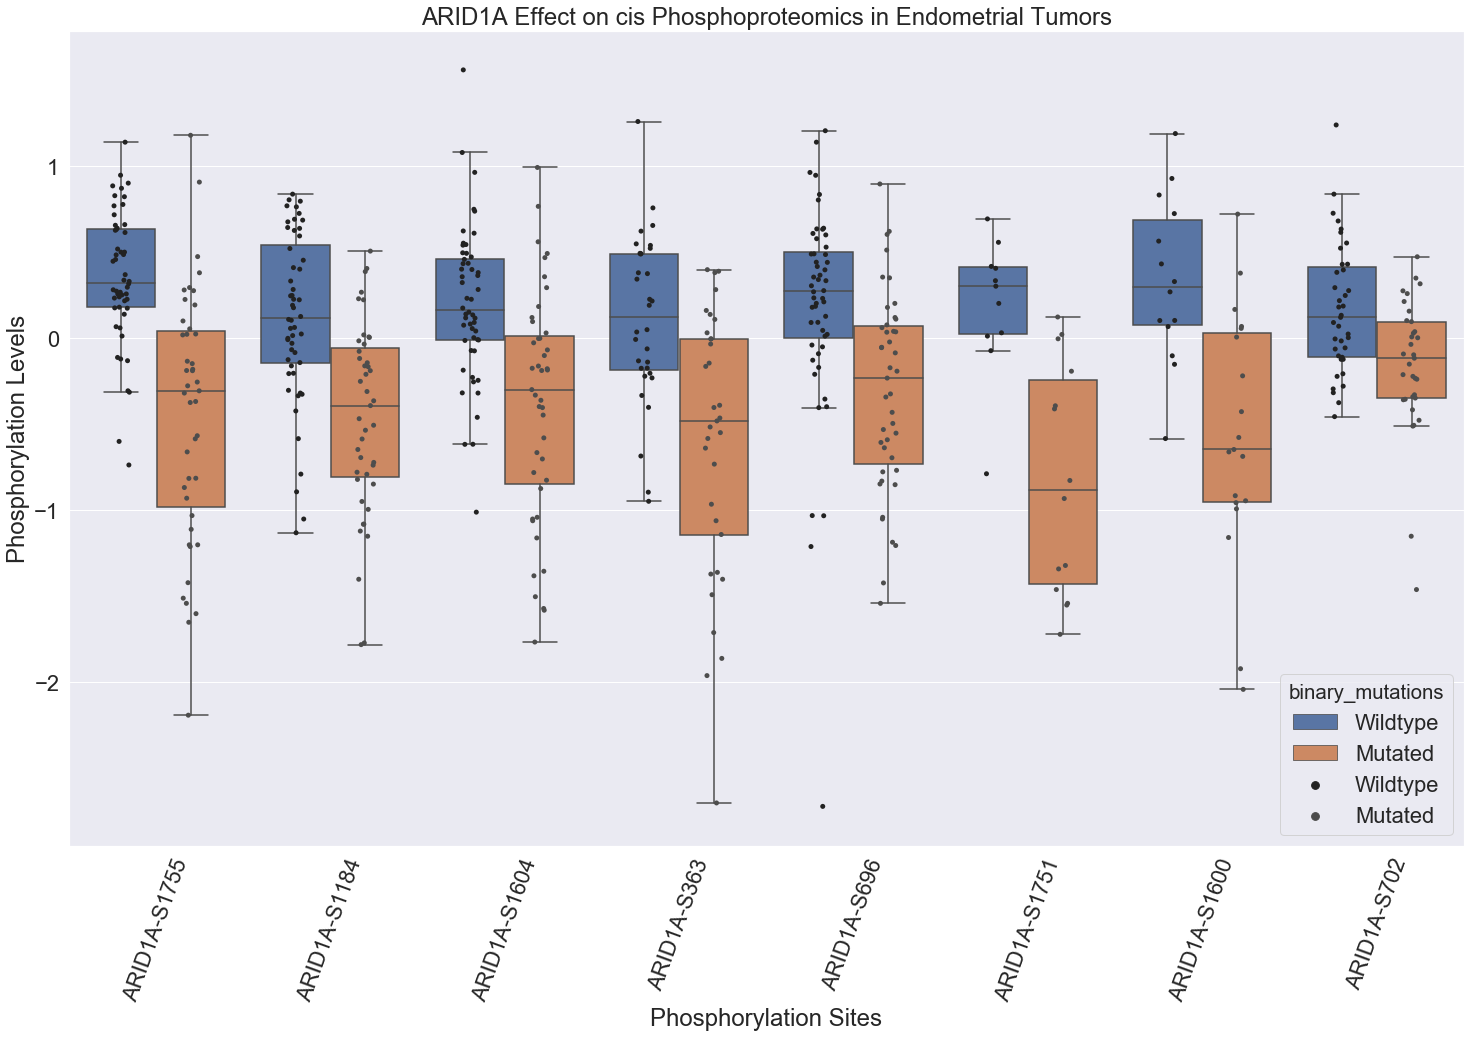

In [65]:
# Step 5 - Create boxplot to compare wildtype and mutated effect on omics data
plt.rcParams['figure.figsize']=(25,15) #size of plot
sns.set(font_scale = 2)
en_cis_boxplot = sns.boxplot(data = sig_phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False)  
en_cis_boxplot.set_title(gene + " Effect on cis Phosphoproteomics in Endometrial Tumors")
en_cis_boxplot = sns.stripplot(data = sig_phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
en_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
en_cis_boxplot.set_xticklabels(en_cis_boxplot.get_xticklabels(),rotation = 70)
plt.show()
plt.clf()
plt.close()

The phosphorylation levels decreased in the mutated samples compared to the wildtype.

Repeat the same steps to compare mutation type (missence vs. truncation). Use the function, get_missence_truncation_comparison, to get the mutation type binary column and format the dataframe.

In [13]:
# Steps 1-3
formated_phospho_mut_type = f.get_missence_truncation_comparison(en_object, 'phosphoproteomics', gene)

In [61]:
# Step 4 - T-test comparing means of missence vs truncation effect on cis omics
print("Doing t-test comparison\n")
sig_pval_mut_type = al.wrap_ttest(formated_phospho_mut_type, 'binary_mutations', omics_col_list)
print(sig_pval_mut_type)

Doing t-test comparison

No significant comparisons.
None


No significant comparisons for mutation type.

# Repeat with the Colon dataset

Go through the same process, this time using the Colon dataset. We will only print five genes from the frequently mutated data frame for simplicity.

In [11]:
colon_object = cptac.Colon()
desired_cutoff = .2

colon_freq_mut = al.get_frequently_mutated(colon_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(colon_freq_mut), '\n')
colon_freq_mut.loc[colon_freq_mut['Gene'] == 'ARID1A']

                                    

Number of Frequently Mutated Genes: 39 



,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
3,ARID1A,0.237113,0.072165,0.185567


In [12]:
gene = 'ARID1A'

co_omics = colon_object.get_phosphoproteomics()

In [13]:
omics_mutations = colon_object.join_omics_to_mutations(
        mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

Phosphoproteomic data for ARID1A does not exist for the endometrial dataset.

# Visualize Pancancer effects

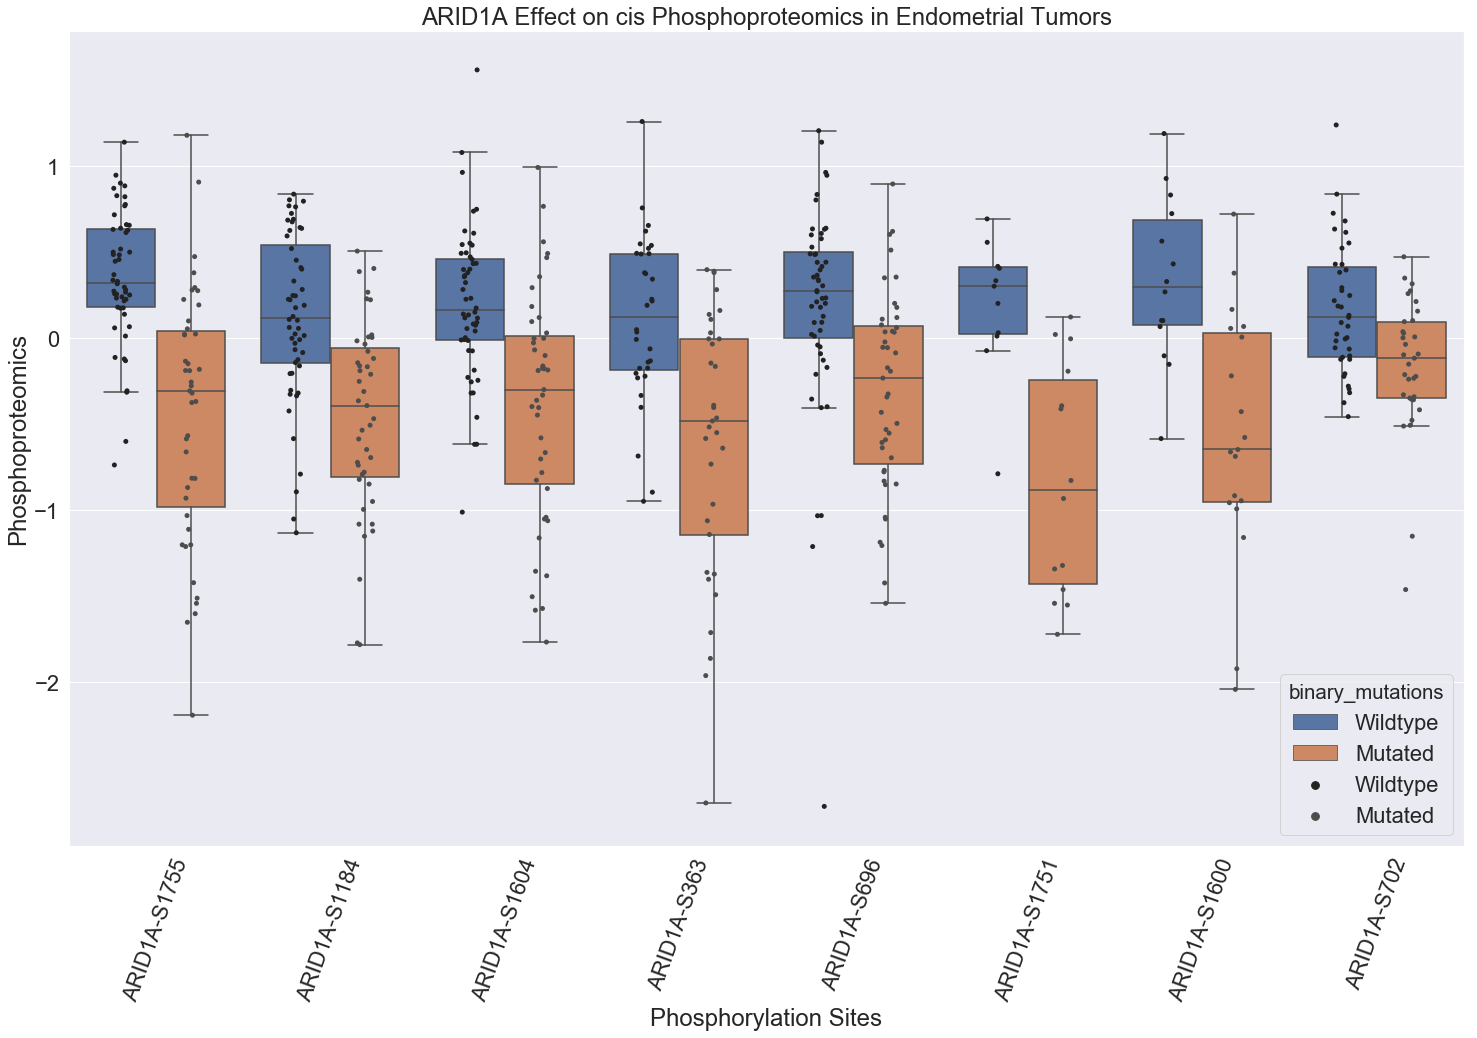

In [63]:
# Step 5 - Create boxplot to compare wildtype and mutated effect on omics data
plt.rcParams['figure.figsize']=(25,15) #size of plot
sns.set(font_scale = 2)
en_cis_boxplot = sns.boxplot(data = sig_phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False)  
en_cis_boxplot.set_title(gene + " Effect on cis Phosphoproteomics in Endometrial Tumors")
en_cis_boxplot = sns.stripplot(data = sig_phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
en_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphoproteomics")
en_cis_boxplot.set_xticklabels(en_cis_boxplot.get_xticklabels(),rotation=70)
plt.show()
plt.clf()
plt.close()

# Analysis of Results

The mutated ARID1A phophorylation levels decreased accross all eight signifcant sites in endometrial cancer. The colon dataset contained no data for ARID1A phosphoproteomics.